# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed:

$$\begin{align}
w(t) =&\ \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)
\end{align}$$

The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

## Solution steps

### 1. Ignore nonlinear stiffness

For now, we ignore the nonlinear stiffness component by setting the parameter $b$ to 0. The state transition thus reduces to:

$$\begin{align}
m x''(t) + v x'(t) + a x(t) = u(t) + w(t) 
\end{align}$$

### 2. Discretize

I'm using an implicit method, for stability reasons.
The backward difference for both derivative terms:

$$\begin{align}
x''(t) \approx&\ \frac{x(t) - 2x(t-h) + x(t-2h)}{h^2} = \frac{x_t - 2x_{t-1} + x_{t-2}}{(\Delta t)^2}\\
x'(t) \approx&\ \frac{x(t) - x(t-h)}{h} = \frac{x_t - x_{t-1}}{\Delta t}\\
\end{align}$$

where $\Delta t = t - (t-1) = 1$. A discretization of the Wiener process yields:

$$\begin{align}
w(t) = \frac{dB(t)}{dt} \approx \frac{B(t) - B(t-h)}{h} = \frac{B_t - B_{t-1}}{\Delta t} \sim \mathcal{N}(0, \tau^{-1}\Delta t) \, .
\end{align}$$

Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The control signal $u(t)$ was constructed from a discrete signal, converted into an analogue signal through a zero-order-hold filter. That means it's a step-function: constant between any $t$ and $t-1$. Since it is an observed variable, we can just convert $u(t)$ straight to $u_t$. The DE can now be written as the following discrete-time system:

$$m (x_t - 2x_{t-1} + x_{t-2}) + v (x_t - x_{t-1}) + a x_t = u_t + w_t$$

Re-writing this in terms of $x_t$ yields:
$$\begin{align}
(m + v + a) x_t&\ + (-2m - v) x_{t-1} + m x_{t-2} = u_t + w_t \\
% x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_t&\ = \frac{2m + v}{m + v + a} x_{t-1} + \frac{-m}{m + v + a} x_{t-2} + \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \, .
\end{align}$$


### 3. Change to shorthand notation:

I'm introducing some shorthand to clean the equation up a bit:

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \, .
\end{align}$$

This produces:
$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \eta w_t
\end{align}$$

Now I'm going to absorb $\eta$ into $w_t$ (using $\mathbb{V}[aX] = a^2\mathbb{V}[X]$):

$$\begin{align}
\mathbb{V}[\eta w_t] = \eta^2 \mathbb{V}[w_t] = \eta^2 \tau^{-1}
\end{align}$$

I will rename $\eta^2 \tau^{-1}$ as $\gamma^{-1}$. This yields

$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \tilde{w}_t
\end{align}$$

where $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. Given four equations and four unknowns, I can recover $m$, $v$, $a$ and $\tau$ from $\theta_1$, $\theta_2$, $\eta$ and $\gamma$.

### 4. Cast to multivariate first-order form

The system now resembles an auto-regressive process:

$$ \underbrace{\begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \theta_1 & \theta_2 \\ 1 & 0 \end{bmatrix}}_{A(\theta)} \underbrace{\begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} \eta \\ 0 \end{bmatrix}}_{B(\eta)} u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, .$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 5. Convert to Gaussian probability

The state transition maps to

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + c\eta u_t, V)$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $V^{-1} = W = \begin{bmatrix} \gamma & 0 \\ 0 & 1/\epsilon \end{bmatrix}$.

The observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \sigma^2)$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}$ and $e_t \sim \mathcal{N}(0, \sigma^2)$.

### 6. Choose priors

I will first study a situation with known measurement noise, i.e., where $\sigma$ is fixed. The mass is a strictly positive parameter, but the damping and stiffness coefficients can be negative. As such, $m$ is modeled by a log-Normal distribution and $v$ and $a$ by a Normal. Process precision $\gamma$ is strictly positive and in this case it is more suitable to use a gamma distribution:

$$\begin{align}
\log(m) \sim&\ \mathcal{N}(m^{0}_m, v^{0}_m) \\
v \sim&\ \mathcal{N}(m^{0}_v, v^{0}_v) \\ 
a \sim&\ \mathcal{N}(m^{0}_a, v^{0}_a) \\
\gamma \sim&\ \Gamma(a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = false;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [5]:
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [6]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

In [101]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    j = Array{T, 2}(undef, n, m)
    for i in 1:n
        j[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return j
end

Jacobian (generic function with 1 method)

In [7]:
# # Start graph
# graph = FactorGraph()

# # Static parameters (log-Normal will be exponentiated in nonlinear function)
# @RV m ~ GaussianMeanPrecision(placeholder(:m_m), placeholder(:w_m)) 
# @RV v ~ GaussianMeanPrecision(placeholder(:m_v), placeholder(:w_v))
# @RV a ~ GaussianMeanPrecision(placeholder(:m_a), placeholder(:w_a))
# @RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# # Nonlinearities
# g1(m,v,a) = [(2*exp(m) + v)/(exp(m) + v + a), -exp(m)/(exp(m) + v + a)]
# g2(m,v,a) = 1/(exp(m) + v + a)
# g3(m,v,a,τ) = τ*(exp(m) + v + a)^2
# @RV θ ~ Nonlinear{Sampling}(m, v, a, g=g1, dims=(2,))
# @RV η ~ Nonlinear{Sampling}(m, v, a, g=g2, dims=(1,))
# @RV γ ~ Nonlinear{Sampling}(m, v, a, τ, g=g3, dims=(1,))

# # Observation selection variable
# c = [1, 0]

# # Measurement precision
# σ = 1e4

# # State prior
# @RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# # Autoregressive node
# @RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), γ, id=:x_t)

# # Specify likelihood
# @RV y_t ~ GaussianMeanPrecision(dot(c, x_t), σ, id=:y_t)

# # Placeholder for observation
# placeholder(y_t, :y_t)

# # Draw time-slice subgraph
# ForneyLab.draw(graph)

# # Infer an algorithm
# q = PosteriorFactorization(z_t, x_t, θ, η, γ, m, v, a, τ, ids=[:z, :x, :θ, :η, :γ, :m, :v, :a, :τ])
# algo = variationalAlgorithm(q, free_energy=false)
# source_code = algorithmSourceCode(algo, free_energy=false)
# eval(Meta.parse(source_code));
# # println(source_code)

FL complains about a loop in the input graph. Next attempt transforms a single vector $\phi = (m, v, a, \tau)$ into another vector $\psi = (\theta_1, \theta_2, \eta, \gamma)$.

In [8]:
# # Start graph
# graph = FactorGraph()

# # Static parameters (log-Normal will be exponentiated in nonlinear function)
# @RV ϕ ~ GaussianMeanPrecision(placeholder(:m_ϕ, dims=(4,)), placeholder(:w_ϕ, dims=(4,4)))

# # Nonlinearities
# g(ϕ) = [(2*exp(ϕ[1])+ϕ[2])/(exp(ϕ[1])+ϕ[2]+ϕ[3]), -exp(ϕ[1])/(exp(ϕ[1])+ϕ[2]+ϕ[3]), 1/(exp(ϕ[1])+ϕ[2]+ϕ[3]), ϕ[4]*(exp(ϕ[1])+ϕ[2]+ϕ[3])^2]
# @RV ψ ~ Nonlinear{Sampling}(ϕ, g=g, dims=(4,))

# # Selection variables
# sel1 = [1. 0. 0. 0.; 
#         0. 1. 0. 0.]
# sel2 = [0. 0. 1. 0.]
# sel3 = [0. 0. 0. 1.]
# c = [1., 0.]

# # Measurement precision
# σ = 1e4

# # State prior
# @RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# # Autoregressive node
# # @RV x_t ~ AutoregressiveControl(ψ[1:2], z_t, ψ[3], placeholder(:u_t), ψ[4], id=:x_t)
# @RV x_t ~ AutoregressiveControl(dot(sel1, ψ), z_t, dot(sel2, ψ), placeholder(:u_t), dot(sel3, ψ), id=:x_t)

# # Specify likelihood
# @RV y_t ~ GaussianMeanPrecision(dot(c, x_t), σ, id=:y_t)

# # Placeholder for observation
# placeholder(y_t, :y_t)

# # Draw time-slice subgraph
# ForneyLab.draw(graph)

# # Infer an algorithm
# q = PosteriorFactorization(z_t, x_t, ϕ, ψ, ids=[:z, :x, :ϕ, :ψ])
# algo = variationalAlgorithm(q, free_energy=false)
# source_code = algorithmSourceCode(algo, free_energy=false)
# eval(Meta.parse(source_code));
# # println(source_code)

I can't select elements of $\psi$ as input to the ARC node. I also can't use selection matrices / vectors as that produces another loop.

I could rewrite the ARC node to accept a parameter vector and send out a combined message

In [78]:
# Start graph
graph1 = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), γ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1., 0.], x_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

# Inference algorithm
q1 = PosteriorFactorization(z_t, x_t, θ, η, γ, ξ, ids=[:z, :x, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code1)

# # Second graph
# graph2 = FactorGraph()

# # Vector of coefficients
# @RV ϕ ~ GaussianMeanPrecision(placeholder(:m_ϕ, dims=(4,)), placeholder(:w_ϕ, dims=(4,4)))

# # Function
# # g(ϕ) = [(2*exp(ϕ[1])+ϕ[2])/(exp(ϕ[1])+ϕ[2]+ϕ[3]), -exp(ϕ[1])/(exp(ϕ[1])+ϕ[2]+ϕ[3]), 1/(exp(ϕ[1])+ϕ[2]+ϕ[3]), exp(ϕ[4])*(exp(ϕ[1])+ϕ[2]+ϕ[3])^2]
# g(ϕ) = [(2*ϕ[1]+ϕ[2])/(ϕ[1]+ϕ[2]+ϕ[3]), -ϕ[1]/(ϕ[1]+ϕ[2]+ϕ[3]), 1/(ϕ[1]+ϕ[2]+ϕ[3]), ϕ[4]*(ϕ[1]+ϕ[2]+ϕ[3])^2]
# g_inv(ψ) = [-ψ[2]/ψ[3], (ψ[1] + 2*ψ[2])/ψ[3], (-ψ[1] -ψ[2] +1)/ψ[3], ψ[4]/ψ[3]^2]

# @RV gϕ ~ Nonlinear{Unscented}(ϕ, g=g, g_inv=g_inv, dims=(4,))

# # Nonlinear node
# @RV ψ ~ GaussianMeanPrecision(gϕ, placeholder(:w_ψ, dims=(4,4)))

# # Psi is inferred by previous graph
# placeholder(ψ, :m_ψ, dims=(4,))

# # # Vector of coefficients
# @RV ψ ~ GaussianMeanPrecision(placeholder(:m_ψ, dims=(4,)), placeholder(:w_ψ, dims=(4,4)))

# # Functions
# g(ϕ) = [(2*ϕ[1]+ϕ[2])/(ϕ[1]+ϕ[2]+ϕ[3]), -ϕ[1]/(ϕ[1]+ϕ[2]+ϕ[3]), 1/(ϕ[1]+ϕ[2]+ϕ[3]), ϕ[4]*(ϕ[1]+ϕ[2]+ϕ[3])^2]
# g_inv(ψ) = [-ψ[2]/ψ[3], (ψ[1] + 2*ψ[2])/ψ[3], (-ψ[1] -ψ[2] +1)/ψ[3], ψ[4]/ψ[3]^2]

# # Physical coefficients
# @RV ϕ ~ Nonlinear{Unscented}(ψ, g=g_inv, g_inv=g, dims=(4,))

# # Draw time-slice subgraph
# ForneyLab.draw(graph2)

# # Inference algorithm
# q2 = PosteriorFactorization(ϕ, ids=[:ϕ])
# algo2 = variationalAlgorithm(q2, free_energy=false)
# source_code2 = algorithmSourceCode(algo2, free_energy=false)
# eval(Meta.parse(source_code2));
# # println(source_code2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14832676206191629514 -->
 
 14832676206191629514 
 
 clamp_1 
 
<!-- 2900595852869513439 -->
 
 2900595852869513439 
 
 placeholder_y_t 
 
<!-- 7737866233071218554 -->
 
 7737866233071218554 
 
 𝒩 
 y_t 
 
<!-- 2900595852869513439--7737866233071218554 -->
 
 2900595852869513439--7737866233071218554 
 
 y_t 
 1 out 
 1 out 
 
<!-- 13689614187170761839 -->
 
 13689614187170761839 
 
 placeholder_w_η 
 
<!-- 5217733715010033382 -->
 
 5217733715010033382 
 
 dot 
 dotproduct_1 
 
<!-- 5217733715010033382--14832676206191629514 -->
 
 5217733715010033382--14832676206191629514 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 16856847442627986589 -->
 
 16856847442627986589 
 
 ARC 
 x_t 
 
<!-- 5217733715010033382--16856847442627986589 -->
 
 5217733715010033382--16856847442627986589 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 7737866233071218554--5217733715010033382 -->
 
 7737866233071218554--5217733715010033382 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 16204552511913018316 -->
 
 16204552511913018316 
 
 Gam 
 gamma_2 
 
<!-- 7737866233071218554--16204552511913018316 -->
 
 7737866233071218554--16204552511913018316 
 
 ξ 
 1 out 
 3 w 
 
<!-- 4367202628929770970 -->
 
 4367202628929770970 
 
 placeholder_m_θ 
 
<!-- 6836320266310535171 -->
 
 6836320266310535171 
 
 placeholder_a_ξ 
 
<!-- 4954292792059851475 -->
 
 4954292792059851475 
 
 placeholder_a_γ 
 
<!-- 14976645849170952423 -->
 
 14976645849170952423 
 
 𝒩 
 z_t 
 
<!-- 17843037017491777044 -->
 
 17843037017491777044 
 
 placeholder_m_z 
 
<!-- 14976645849170952423--17843037017491777044 -->
 
 14976645849170952423--17843037017491777044 
 
 m_z 
 1 out 
 2 m 
 
<!-- 3563568482453347843 -->
 
 3563568482453347843 
 
 placeholder_w_z 
 
<!-- 14976645849170952423--3563568482453347843 -->
 
 14976645849170952423--3563568482453347843 
 
 w_z 
 1 out 
 3 w 
 
<!-- 11011856803609974261 -->
 
 11011856803609974261 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 11011856803609974261--13689614187170761839 -->
 
 11011856803609974261--13689614187170761839 
 
 w_η 
 1 out 
 3 w 
 
<!-- 5299929484355142510 -->
 
 5299929484355142510 
 
 placeholder_m_η 
 
<!-- 11011856803609974261--5299929484355142510 -->
 
 11011856803609974261--5299929484355142510 
 
 m_η 
 1 out 
 2 m 
 
<!-- 14189366701393741290 -->
 
 14189366701393741290 
 
 placeholder_b_γ 
 
<!-- 2250664876445218908 -->
 
 2250664876445218908 
 
 placeholder_b_ξ 
 
<!-- 5971121124422417845 -->
 
 5971121124422417845 
 
 placeholder_w_θ 
 
<!-- 13657085879222378337 -->
 
 13657085879222378337 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 13657085879222378337--4367202628929770970 -->
 
 13657085879222378337--4367202628929770970 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 13657085879222378337--5971121124422417845 -->
 
 13657085879222378337--5971121124422417845 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 16204552511913018316--6836320266310535171 -->
 
 16204552511913018316--6836320266310535171 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 16204552511913018316--2250664876445218908 -->
 
 16204552511913018316--2250664876445218908 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 16856847442627986589--14976645849170952423 -->
 
 16856847442627986589--14976645849170952423 
 
 z_t 
 1 out 
 2 x 
 
<!-- 16856847442627986589--11011856803609974261 -->
 
 16856847442627986589--11011856803609974261 
 
 η 
 1 out 
 4 η 
 
<!-- 16856847442627986589--13657085879222378337 -->
 
 16856847442627986589--13657085879222378337 
 
 θ 
 1 out 
 3 θ 
 
<!-- 6719358913692556869 -->
 
 6719358913692556869 
 
 placeholder_u_t 
 
<!-- 16856847442627986589--6719358913692556869 -->
 
 16856847442627986589--6719358913692556869 
 
 u_t 
 1 out 
 5 u 
 
<!-- 15756267166347579017 -->
 
 15756267166347579017 
 
 Gam 
 gamma_1 
 
<!-- 16856847442627986589--15756267166347579017 -->
 
 16856847442627986589--15756267

In [102]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), 0.1*ones(1,T+1))
params_γ = (0.01*ones(1,T+1), 0.01*ones(1,T+1))
params_ξ = (1e5*ones(1,T+1), 1e1*ones(1,T+1))
params_ϕ = (zeros(4,T+1), repeat(.1 .*float(eye(4)), outer=(1,1,T+1)))

# Initialize physical coefficient estimate arrays
params_m = (zeros(T,), zeros(T,))
params_v = (zeros(T,), zeros(T,))
params_a = (zeros(T,), zeros(T,))
params_τ = (zeros(T,), zeros(T,))


# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    # Data dict
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]
    
#     # Concatenate θ,η,γ to ψ
#     data[:m_ψ] = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:η])[1], unsafeMean(marginals[:γ])[1]]
#     data[:w_ψ] = Diagonal([unsafePrecision(marginals[:θ])[1,1], unsafePrecision(marginals[:θ])[2,2], unsafePrecision(marginals[:η])[1,1], inv(unsafeVar(marginals[:γ])[1,1])])
#     data[:m_ϕ] = params_ϕ[1][:,t]
#     data[:w_ϕ] = params_ϕ[2][:,:,t]
    
#     # Initialize marginal
#     marginals[:ϕ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(4,), w=Matrix{Float64}(I,4,4))
    
#     # Iterate updates
#     for i = 1:num_iterations
#        stepϕ!(data, marginals) 
#     end
    
#     # Update inferred params
#     params_ϕ[1][:,t+1] = unsafeMean(marginals[:ϕ])
#     params_ϕ[2][:,:,t+1] = unsafePrecision(marginals[:ϕ])
    
    # Approximate gamma with log-normal
    m_lγ = unsafeMean(marginals[:γ])
    v_lγ = unsafeVar(marginals[:γ])

    # Transform process noise variable: γ ~ logNormal(μ_lγ, v_lγ) => log(γ) ~ Normal(m_γ, v_γ) 
    m_γ = 2*log(m_lγ) - 1/2*log(v_lγ + m_lγ^2)
    v_γ = -2*log(m_lγ) + log(v_lγ + m_lγ^2)

    # Parameter estimates of ψ
    m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:η])[1], m_γ]
    W_ψ = Diagonal([unsafePrecision(marginals[:θ])[1,1], unsafePrecision(marginals[:θ])[2,2], unsafePrecision(marginals[:η])[1,1], inv(v_γ)])

    # Transformation ψ = G(ϕ) and ϕ = G_inv(ψ)
    g_inv(ψ) = [-ψ[2]/ψ[3], (ψ[1] + 2*ψ[2])/ψ[3], (-ψ[1] -ψ[2] +1)/ψ[3], ψ[4]/ψ[3]^2]
    J_mϕ = Jacobian(g_inv, m_ψ)
    m_ϕ = g_inv(m_ψ)
    V_ϕ = J_mϕ*inv(W_ψ)*J_mϕ'

    # Split ϕ into physical coefficients
    m_m, m_v, m_a, m_τ = m_ϕ
    v_m, v_v, v_a, v_τ = Diagonal(V_ϕ)

    # Transform mass variable: log(m) ~ N(m_m, v_m) => m ~ logNormal(m_lm, v_lm)
    m_lm = exp(m_m + 1/2*v_m)
    v_lm = exp(2*m_m + v_m)*(exp(v_m) - 1)

    # Transform process noise variable: log(τ) ~ N(m_τ, v_τ) => m ~ logNormal(m_lτ, v_lτ)
    m_lτ = exp(m_τ + 1/2*v_τ)
    v_lτ = exp(2*m_τ + v_τ)*(exp(v_τ) - 1)
    
    # Store params
    params_m[1][t] = m_lm
    params_m[2][t] = v_lm
    params_v[1][t] = m_v
    params_v[2][t] = v_v
    params_a[1][t] = m_a
    params_a[2][t] = v_a
    params_τ[1][t] = m_lτ
    params_τ[2][t] = v_lτ

end

At time 100%|███████████████████████████████████████████| Time: 0:02:28


In [109]:
v_τ

0.0

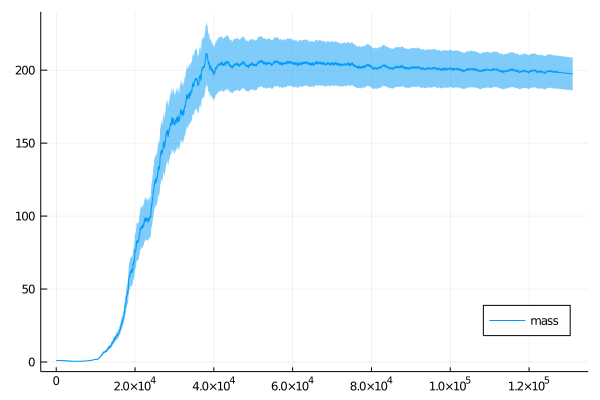

In [104]:
plot(1:10:T, params_m[1][1:10:T], ribbon=[sqrt.(params_m[2][1:10:T]) sqrt.(params_m[2][1:10:T])], label="mass", legend=:bottomright)

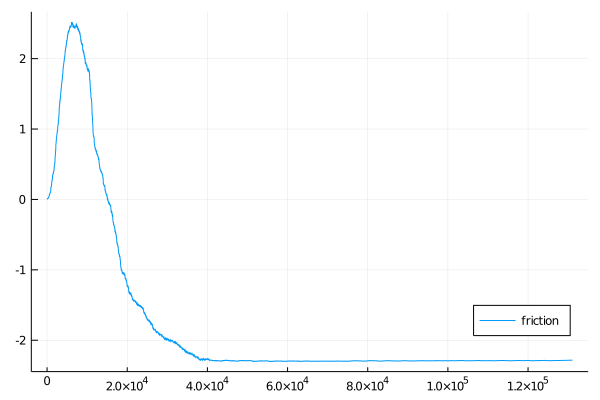

In [105]:
plot(1:10:T, params_v[1][1:10:T], ribbon=[sqrt.(params_v[2][1:10:T]) sqrt.(params_v[2][1:10:T])], label="friction", legend=:bottomright)

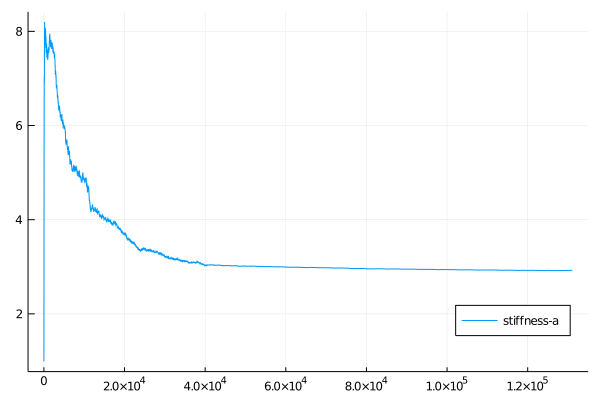

In [106]:
plot(1:10:T, params_a[1][1:10:T], ribbon=[sqrt.(params_a[2][1:10:T]) sqrt.(params_a[2][1:10:T])], label="stiffness-a", legend=:bottomright)

In [107]:
plot(1:10:T, params_τ[1][1:10:T], ribbon=[sqrt.(params_τ[2][1:10:T]) sqrt.(params_τ[2][1:10:T])], label="process-precision", legend=:bottomright)

In [93]:
# Approximate gamma with log-normal
m_lγ = unsafeMean(marginals[:γ])
v_lγ = unsafeVar(marginals[:γ])

# Transform process noise variable: γ ~ logNormal(μ_lγ, v_lγ) => log(γ) ~ Normal(m_γ, v_γ) 
m_γ = 2*log(m_lγ) - 1/2*log(v_lγ + m_lγ^2)
v_γ = -2*log(m_lγ) + log(v_lγ + m_lγ^2)

# Parameter estimates of ψ
m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:η])[1], m_γ]
W_ψ = Diagonal([unsafePrecision(marginals[:θ])[1,1], unsafePrecision(marginals[:θ])[2,2], unsafePrecision(marginals[:η])[1,1], inv(v_γ)])

# Transformation ψ = G(ϕ) and ϕ = G_inv(ψ)
g_inv(ψ) = [-ψ[2]/ψ[3], (ψ[1] + 2*ψ[2])/ψ[3], (-ψ[1] -ψ[2] +1)/ψ[3], ψ[4]/ψ[3]^2]
J_mϕ = Jacobian(g_inv, m_ψ)
m_ϕ = g_inv(m_ψ)
V_ϕ = J_mϕ*inv(W_ψ)*J_mϕ'

# Split ϕ into physical coefficients
m_m, m_v, m_a, m_τ = m_ϕ
v_m, v_v, v_a, v_τ = Diagonal(V_ϕ)

# Transform mass variable: log(m) ~ N(m_m, v_m) => m ~ logNormal(m_lm, v_lm)
m_lm = exp(m_m + 1/2*v_m)
v_lm = exp(2*m_m + v_m)*(exp(v_m) - 1)

# Transform process noise variable: log(τ) ~ N(m_τ, v_τ) => m ~ logNormal(m_lτ, v_lτ)
m_lτ = exp(m_τ + 1/2*v_τ)
v_lτ = exp(2*m_τ + v_τ)*(exp(v_τ) - 1)

0.0

In [100]:
V_ϕ

4×4 Array{Float64,2}:
  0.0032262   -0.00143267    0.00179621    0.350555
 -0.00143267   0.000719888  -0.000838515  -0.151493
  0.00179621  -0.000838515   0.00102872    0.193983
  0.350555    -0.151493      0.193983     38.4017

In [55]:
println(source_code2)

begin

function stepϕ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_ϕ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_ϕ]))
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Multivariate, PointMass, m=data[:m_ψ]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_ψ]))
messages[3] = ruleSPNonlinearUTIn1GG(g, g_inv, messages[2], nothing)
messages[4] = ruleSPNonlinearUTOutNG(g, nothing, messages[1])

marginals[:gϕ] = messages[4].dist * messages[2].dist
marginals[:ϕ] = messages[1].dist * messages[3].dist

return marginals

end

end # block


In [56]:
messages = Array{Message}(undef, 4)

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_ϕ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_ϕ]))
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Multivariate, PointMass, m=data[:m_ψ]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_ψ]))
messages[3] = ruleSPNonlinearUTIn1GG(g, g_inv, messages[2], nothing)
messages[4] = ruleSPNonlinearUTOutNG(g, nothing, messages[1])

marginals[:gϕ] = messages[4].dist * messages[2].dist
marginals[:ϕ] = messages[1].dist * messages[3].dist

𝒩(xi=[1.52e+09, 1.52e+09, 1.52e+09, -3.00e+04], w=[[1.56e+09, -4.23e+08, -2.10e+09, -1.00e+04][-4.23e+08, 2.99e+09, 4.06e+09, -1.00e+04][-2.10e+09, 4.06e+09, 7.87e+09, -1.00e+04][-1.00e+04, -1.00e+04, -1.00e+04, 0.31]])


In [42]:
messages[3].dist.params[:v]

4×4 Array{Float64,2}:
  1.83017e21  -4.04406e17   1.26002e17        4.08241e9
 -3.49358e17   7.71961e13  -2.40522e13  -779281.0
  6.21724e17  -1.3738e14    4.28038e13        1.38682e6
 -1.3244e17    2.92647e13  -9.11807e12  -295422.0

In [12]:
begin

function initϕ()

messages = Array{Message}(undef, 2)

messages[1] = Message(vague(GaussianMeanPrecision))

return messages

end

function stepϕ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_ϕ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:w_ϕ]))
messages[2] = ruleSPNonlinearSIn1MN(g, Message(Univariate, PointMass, m=data[:m_ψ]), nothing)

marginals[:ϕ] = messages[1].dist * messages[2].dist

return marginals

end

end # block

stepϕ! (generic function with 3 methods)

### Visualize results

In [13]:
viz = true

true

In [14]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1400,600), xlabel="time (t)", ylabel="response")
    Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/estimated_states01.png")
end

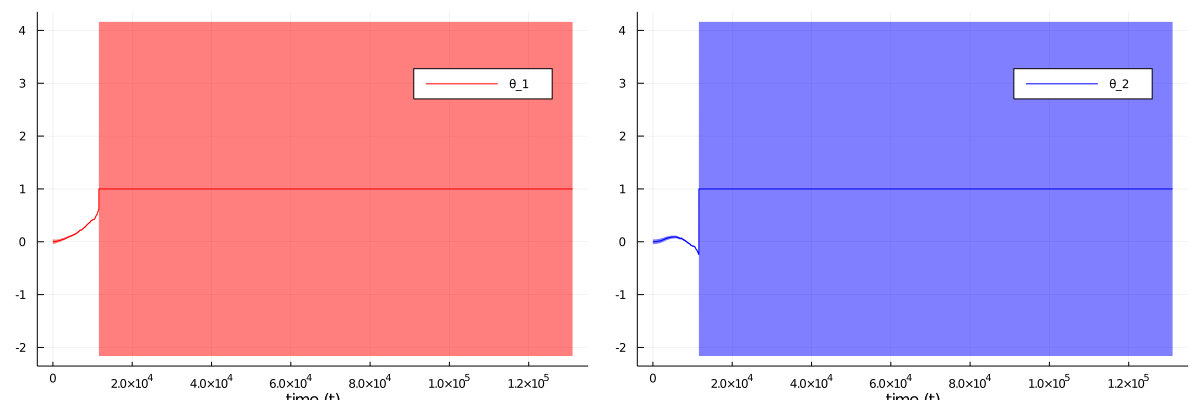

In [15]:
# Extract mean of coefficient marginals
estimated_coeffs_1_mean = params_θ[1][1,2:end]
estimated_coeffs_1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_coeffs_2_mean = params_θ[1][2,2:end]
estimated_coeffs_2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))

if viz
    
#     # Plot both coefficients within the same figure
#     Plots.plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)", ylim=[-1.5, 1.5])
#     Plots.plot!(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ_2")
# #     Plots.savefig("viz/estimated_coeffs.png")
    
    # Plot both coefficients next to each other
    p2a = Plots.plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)")
    p2b = Plots.plot(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ_2", xlabel="time (t)")
    p2 = plot(p2a, p2b, size=(1200,400))
#     Plots.savefig(p2, "viz/estimated_coeffs_subp.png")
end

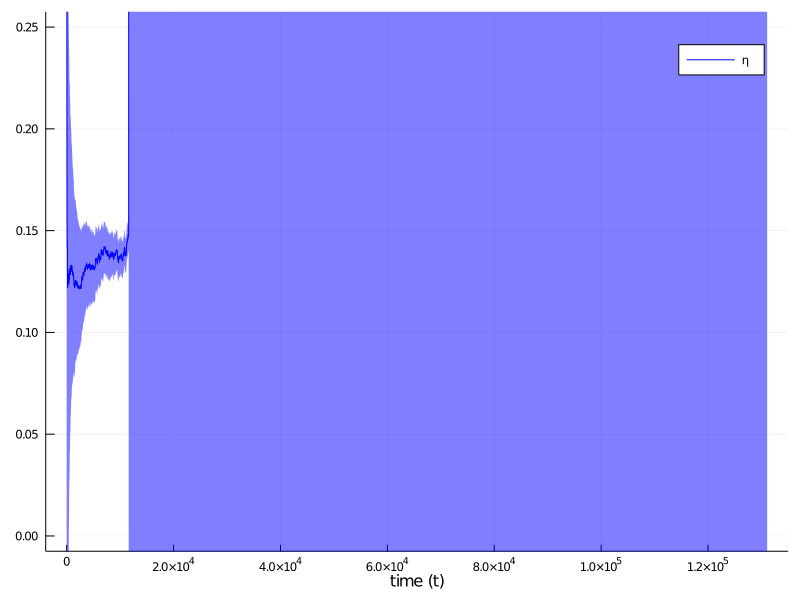

In [16]:
# Extract mean of control coefficient marginals
estimated_ccoeff_mean = params_η[1][1,2:end]
estimated_ccoeff_std = sqrt.(inv.(params_η[2][1,2:end]))

if viz
    # Plot both coefficients next to each other
    p3 = Plots.plot(1:n:T, estimated_ccoeff_mean[1:n:T], ribbon=[estimated_ccoeff_std[1:n:T], estimated_ccoeff_std[1:n:T]], color="blue", label="η", xlabel="time (t)", size=(800,600), ylim=[0.0, 0.25])
#     Plots.savefig(p3, "viz/estimated_ccoeff.png")
end

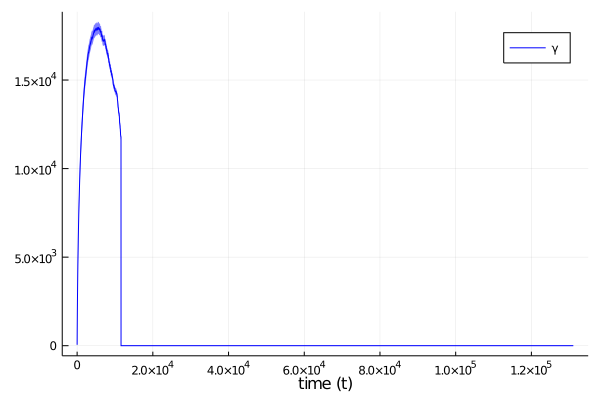

In [17]:
# Extract mean of process precision marginals
estimated_pnoise_mean = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
estimated_pnoise_std = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p4 = Plots.plot(1:n:T, estimated_pnoise_mean[1:n:T], ribbon=[estimated_pnoise_std[1:n:T], estimated_pnoise_std[1:n:T]],color="blue", label="γ", xlabel="time (t)")
#     Plots.savefig(p4, "viz/estimated_pnoise.png")
end

## Solving nonlinear system of equations

We currently have estimates for $\theta_1$, $\theta_2$, and $\eta$. But we want to know the original coefficients, $m$, $v$ and $a$, which actually have a physical meaning. To obtain estimates for those, we have to solve the following nonlinear system of equations:

$$\begin{align} 
\hat{\theta}_1 =&\ \frac{2m + v}{m + v + a} \\
\hat{\theta}_2 =&\ \frac{-m}{m + v + a} \\
\hat{\eta} =&\ \frac{1}{m + v + a} \\
\hat{\gamma}^{-1} =&\ \frac{1}{\tau (m + v + a)^2}
\end{align}$$

Implementation using NLsolve.jl

In [18]:
using NLsolve

In [19]:
# Current estimates of parameters
global estimates = [estimated_coeffs_1_mean[end], estimated_coeffs_2_mean[end], estimated_ccoeff_mean[end], inv(estimated_pnoise_mean[end])]

4-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0

In [20]:
# Define nonlinear system of equations
function F!(F, x)
    F[1] = (2*x[1] + x[2])/(x[1] + x[2] + x[3])  - estimates[1]
    F[2] = (-x[1])/(x[1] + x[2] + x[3]) - estimates[2]
    F[3] = 1/(x[1] + x[2] + x[3]) - estimates[3]
    F[4] = 1/(x[4]*(x[1] + x[2] + x[3])^2) - estimates[4] 
end

# Jacobian of each equation
function J!(J, x)
    
    # F[1]
    J[1, 1] = (x[2] + 2*x[3])/(x[1] + x[2] + x[3])^2
    J[1, 2] = (x[3] - x[1])/(x[1] + x[2] + x[3])^2
    J[1, 3] = (-2*x[1] - x[2])/(x[1] + x[2] + x[3])^2
    J[1, 4] = 0.
    
    # F[2]
    J[2, 1] = (x[2] + x[3])/(x[1] + x[2] + x[3])^2
    J[2, 2] = x[1]/(x[1] + x[2] + x[3])^2
    J[2, 3] = x[1]/(x[1] + x[2] + x[3])^2
    J[2, 4] = 0.
    
    # F[3]
    J[3, 1] = -1/(x[1] + x[2] + x[3])^2
    J[3, 2] = -1/(x[1] + x[2] + x[3])^2
    J[3, 3] = -1/(x[1] + x[2] + x[3])^2
    J[3, 4] = 0.
    
    # F[4]
    J[4, 1] = -1/(2*x[4]*(x[1] + x[2] + x[3])^(3/2))
    J[4, 2] = -1/(2*x[4]*(x[1] + x[2] + x[3])^(3/2))
    J[4, 3] = -1/(2*x[4]*(x[1] + x[2] + x[3])^(3/2))
    J[4, 4] = -1/(x[4]^2*sqrt(x[1] + x[2] + x[3]))
    
end

# Call solver
# x_solved = nlsolve(F!, J!, [1. 1. 1. 1.])
x_solved = nlsolve(F!, [1. 1. 1. 1.], autodiff=:forward)

# Extract new estimates
global m, v, a, τ = x_solved.zero

1×4 Array{Float64,2}:
 NaN  NaN  NaN  NaN

So, in total we estimate the dynamical parameters as follows:

In [21]:
println("m = " *string(m))
println("v = " *string(v))
println("a = " *string(a))
println("τ = " *string(τ))

m = NaN
v = NaN
a = NaN
τ = NaN


Now, I'm going to estimate the dynamical parameters for the entire trajectory. Note that I could do this at inference time as well.

In [22]:
m = zeros(T,1)
v = zeros(T,1)
a = zeros(T,1)
τ = zeros(T,1)

# Extract means of marginals
estimated_θ1 = params_θ[1][1,2:end]
estimated_θ2 = params_θ[1][2,2:end]
estimated_η = params_η[1][1,2:end]
estimated_γ = inv.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end])

for t = 1:T
    
    function F!(F, x)
        F[1] = (2*x[1] + x[2])/(x[1] + x[2] + x[3])  - estimated_θ1[t]
        F[2] = (-x[1])/(x[1] + x[2] + x[3]) - estimated_θ2[t]
        F[3] = 1/(x[1] + x[2] + x[3]) - estimated_η[t]
        F[4] = 1/(x[4]*(x[1] + x[2] + x[3])^2) - estimated_γ[t] 
    end
    
    # Call solver
#     x_solved = nlsolve(F!, J!, [1. 1. 1. 1.])
    x_solved = nlsolve(F!, [0.1 0.1 0.1 0.1], autodiff=:forward)

    # Extract new estimates
    m[t], v[t], a[t], τ[t] = x_solved.zero
    
end

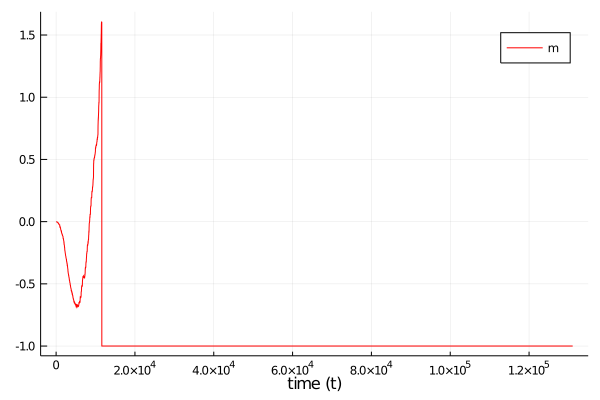

In [23]:
# Plot belief evolution for mass
Plots.plot(1:n:T, m[1:n:T], color="red", label="m", xlabel="time (t)")

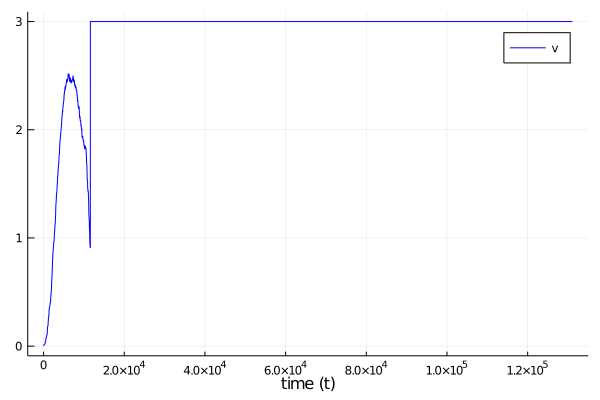

In [24]:
# Plot belief evolution for friction coefficient
Plots.plot(1:n:T, v[1:n:T], color="blue", label="v", xlabel="time (t)")

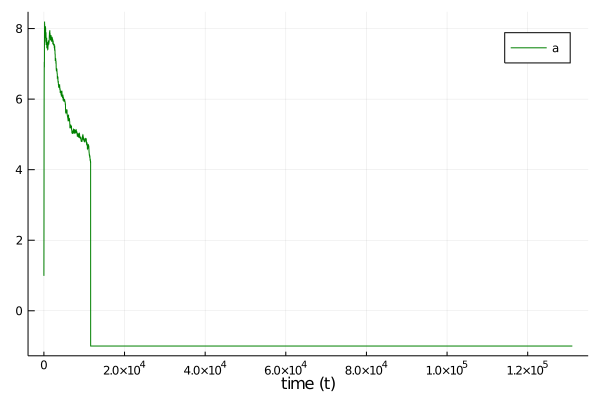

In [25]:
# Plot belief evolution for linear stiffness
Plots.plot(1:n:T, a[1:n:T], color="green", label="a", xlabel="time (t)")

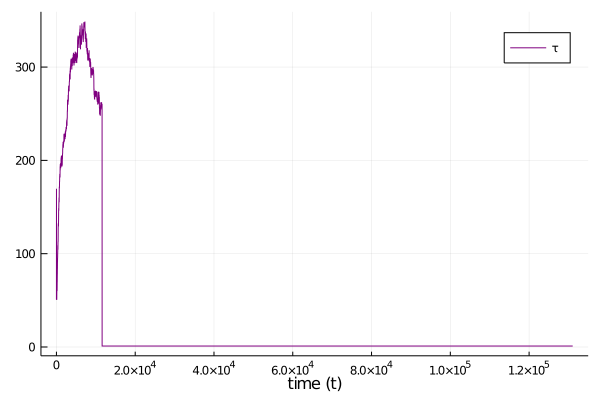

In [26]:
# Plot belief evolution for process precision
Plots.plot(1:n:T, τ[1:n:T], color="purple", label="τ", xlabel="time (t)")